# A Short Intro to Neural Networks

For the idea behind neural networks, see the chalkboard video. It's not so easy to draw a network in a Jupyter notebook, so we'll focus on the code here.

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.datasets import reuters
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer # We'll use Keras's own tokenizer for our NLP preprocessing here

Using TensorFlow backend.


Our example data set today is from the Reuters news agency. This is a subset of a larger data set that is a standard benchmark in document classification. The text of the articles has already been preprocessed, and is represented as a sequence of integer indices, with each index representing a word in the data set's vocabulary.

The target is a categorical variable with 46 levels representing the topics of articles.

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=759,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)
word_index = reuters.get_word_index(path="reuters_word_index.json")
topic_index = {'copper': 6, 'livestock': 28, 'gold': 25, 'money-fx': 19, 'ipi': 30, 'trade': 11, 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}
index_to_topic = {}
for key, value in topic_index.items():
    index_to_topic[value] = key
index_to_word = {}
for key, value in word_index.items():
    index_to_word[value] = key

In [5]:
idx = np.random.choice(len(x_train))
print(x_train[idx])
print(y_train[idx])

[1, 53, 119, 26, 14, 119, 26, 39, 19, 7139, 18, 14, 19, 4701, 18, 1730, 296, 61, 11, 14, 258, 59, 11, 151, 177, 53, 981, 26, 14, 745, 26, 39, 44, 4722, 18, 14, 47, 2013, 18, 1730, 482, 72, 11, 14, 533, 72, 11, 123, 383, 48, 90, 67, 563, 1974, 12825, 642, 5, 79, 582, 13, 93, 48, 1051, 4430, 2630, 326, 382, 685, 23, 21606, 1568, 149, 17, 12]
3


Let's explore what this data looks like a bit first.

In [6]:
print(' '.join([index_to_word[i] for i in x_train[idx]]))
print(index_to_topic[y_train[idx]])

the lt production year reuter production year an from shippers on reuter from declaration on lowered did had vs reuter shareholders were vs rise avg lt ahead year reuter august year an 4 mediterranean on reuter which severe on lowered account also vs reuter number also vs some budget but april 0 65 minority breweries senior said tonnes past it price but drilling franklin clients recent sold 43 cts warplnes big added pct dlrs
earn


In [7]:
set(topic_index)

{'acq',
 'alum',
 'bop',
 'carcass',
 'cocoa',
 'coffee',
 'copper',
 'cotton',
 'cpi',
 'crude',
 'dlr',
 'earn',
 'gas',
 'gnp',
 'gold',
 'grain',
 'heat',
 'hog',
 'housing',
 'interest',
 'ipi',
 'iron-steel',
 'jobs',
 'lead',
 'lei',
 'livestock',
 'meal-feed',
 'money-fx',
 'money-supply',
 'nat-gas',
 'oilseed',
 'orange',
 'pet-chem',
 'reserves',
 'retail',
 'rubber',
 'ship',
 'silver',
 'strategic-metal',
 'sugar',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'zinc'}

Do some necessary preprocessing:

In [8]:
max_words = 1000 # Arbitrary choice
num_classes = np.max(y_train) + 1

tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

y_train = keras.utils.to_categorical(y_train, num_classes) # Remember this for the assignment;
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
y_train[idx]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<font color = 'green'> __Artificial neural network:__ <font color = 'black'> A model built out of a "network" of simple models called "neurons". Each neuron takes as its input a vector $\mathbf x$, dots it with a "weight vector" $\mathbf w$ which is specific to that neuron, optionally adds a bias $b$, and then evaluates a mathematical function to produce a single number as output.

<font color = 'green'> __Layer:__ <font color = 'black'> A neural network is made out of a sequence of layers. Each layer is made of several neurons which take input vectors from the previous layer and pass output to the next layer. (Note the output of a neuron is a single number, so the input vector is formed out of the output of multiple neurons from the previous layer.) In general, all neurons in the same layer are the same type but will have different weights.

<font color = 'green'> __Hidden layer:__ <font color = 'black'> A network always has an input layer, which "reads" the data. Often the input layer is just one neuron for each predictor, which simply passes that predictor unmodified onto the next layer. A network also always has an output layer, which produces the output prediction. For classification problems, this usually has one neuron per class, which produces the estimated class probability.
    
Layers in between the input and output are called *hidden layers.* A network with many hidden layers is called a *deep* neural network.

<font color = 'green'> __Dense feed-forward network:__ <font color = 'black'> One of the simplest forms of neural network. "Feed forward" means that data travels through the network from input to output without any backtracking, loops, or other complex paths. "Dense" means that every neuron in layer $i$ feeds into every neuron in layer $i + 1$. That is, the network contains every possible connection.

The type of feed-forward network we are constructing here is also called a *multilayer perceptron* (MLP).

<font color = 'green'> __Activation function:__ <font color = 'black'> As mentioned before, each neuron produces its output by calculating a linear function of the input, $\mathbf w \cdot \mathbf x + b$, and then evaluating a mathematical function on the result. That function is called the *activation function*. Several common choices of activation function:

**Sigmoid** (aka logistic):

$$ f(x) = \frac{1}{1 + e^{-x}} $$

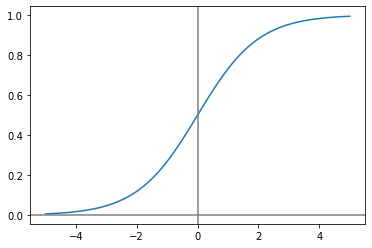

In [10]:
x = np.linspace(-5, 5, 100)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.show()

**Tanh** (hyperbolic tangent):

$$ f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

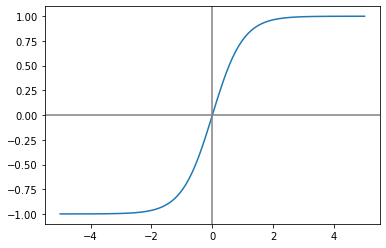

In [11]:
x = np.linspace(-5, 5, 100)
y = np.tanh(x)
plt.plot(x, y)
plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.show()

**Rectified linear unit** (ReLU)

$$ f(x) = \max(0, x) $$

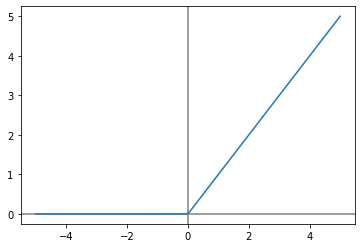

In [12]:
x = np.linspace(-5, 5, 100)
y = np.zeros_like(x)
y[50:] = x[50:]
plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.plot(x, y)
plt.show()

<font color = 'green'> __Backpropagation:__ <font color = 'black'> The standard approach to training a neural network is to use some variant of stochastic gradient descent. This requires that we are able to calculate the gradient of the loss function with respect to the individual weights. This can be done relatively efficiently by the "backpropagation" algorithm.
 
We won't go into the mathematical details, but the rough idea is that after making a prediction and measuring its error (how far off the correct target it was), the error can be traced back through the network. Multiplying together activations and their individual gradients as we go, we get the gradients with respect to the weights in each neuron. So there is a forward pass (making the prediction) and a backward pass (backpropagating the error to get the gradient).

<font color = 'green'> __Vanishing gradient problem:__ <font color = 'black'> Another consequence of multiplying together many small numbers. If we use backpropagation on a deep network, and the activations/gradients for individual neurons are small, then by the time we get to the "early" layers we have multiplied together many small numbers, and the gradient is very small. This means our gradient descent will take very small steps and the early layers will not learn quickly.

The vanishing gradient problem can be mitigated by:
* Different network architectures that can preserve gradients back through the network
* Variations on SGD that scale the gradient to counterbalance this effect
* Using activations that are less susceptible to vanishing gradients, such as ReLU

## Using Keras to create a neural network

Setting up a model in Keras has three steps:

1. Initialize the model object and add layers
2. "Compile" the model to prepare it for training
3. Train the model

In [13]:
# Initialize the model
model = Sequential()
# Add layers
# We need to specify the input size for the first layer. Later layers can infer it from the size of the 
# previous layer.
model.add(Dense(512, input_shape = (max_words,), activation = 'sigmoid')) # Input layer with 512 neurons
model.add(Dense(256, activation = 'sigmoid')) # Hidden layer with 256 neurons
model.add(Dense(128, activation = 'sigmoid')) # Hidden layer with 256 neurons
model.add(Dense(46, activation = 'softmax')) # Softmax output for multiclass classification. 46 = # classes

In [14]:
# Compile the model.
model.compile(loss='categorical_crossentropy',  # Loss function for multiclass classification
              optimizer='sgd',                  # Stochastic gradient descent for optimization
              metrics=['accuracy'])             # Use prediction accuracy to assess model during training

In [15]:
model.fit(x_train, y_train, batch_size = 32, epochs = 1)

Epoch 1/1
8982/8982 [==============================] - 1s 128us/step - loss: 2.5741 - accuracy: 0.3388


We've started training! But 1 epoch really isn't enough.

In [16]:
model.fit(x_train, y_train, batch_size = 32, epochs = 25)

Epoch 1/25
8982/8982 [==============================] - 1s 83us/step - loss: 2.4168 - accuracy: 0.3552
Epoch 2/25
8982/8982 [==============================] - 1s 81us/step - loss: 2.4069 - accuracy: 0.3552
Epoch 3/25
8982/8982 [==============================] - 1s 91us/step - loss: 2.4035 - accuracy: 0.3552
Epoch 4/25
8982/8982 [==============================] - 1s 87us/step - loss: 2.4006 - accuracy: 0.3552
Epoch 5/25
8982/8982 [==============================] - 1s 82us/step - loss: 2.3984 - accuracy: 0.3552
Epoch 6/25
8982/8982 [==============================] - 1s 84us/step - loss: 2.3961 - accuracy: 0.3552
Epoch 7/25
8982/8982 [==============================] - 1s 88us/step - loss: 2.3941 - accuracy: 0.3552
Epoch 8/25
8982/8982 [==============================] - 1s 85us/step - loss: 2.3915 - accuracy: 0.3552
Epoch 9/25
8982/8982 [==============================] - 1s 90us/step - loss: 2.3883 - accuracy: 0.3552
Epoch 10/25
8982/8982 [==============================] - 1s 83us/step - l

Notice we don't see any improvement for the first 15 or so epochs. This is a network that suffers from a mild case of the vanishing gradient problem. We can greatly improve training speed if we change from sigmoid activation to ReLU:

In [18]:
# Initialize the model
model = Sequential()
# Add layers
# We need to specify the input size for the first layer
model.add(Dense(512, input_shape = (max_words,), activation = 'relu')) # Input layer with 512 neurons
model.add(Dense(256, activation = 'relu')) # Hidden layer with 128 neurons
model.add(Dense(128, activation = 'relu')) # Hidden layer with 128 neurons
model.add(Dense(46, activation = 'softmax')) # Softmax output for multiclass classification. 46 = # classes

# Compile the model
# Compile the model.
model.compile(loss='categorical_crossentropy',  # Loss function for multiclass classification
              optimizer='sgd',                  # Stochastic gradient descent for optimization
              metrics=['accuracy'])             # Use prediction accuracy to assess model during training

In [19]:
model.fit(x_train, y_train, batch_size = 32, epochs = 25)

Epoch 1/25
8982/8982 [==============================] - 1s 105us/step - loss: 2.3881 - accuracy: 0.4334
Epoch 2/25
8982/8982 [==============================] - 1s 83us/step - loss: 1.7161 - accuracy: 0.5766
Epoch 3/25
8982/8982 [==============================] - 1s 81us/step - loss: 1.5486 - accuracy: 0.6523
Epoch 4/25
8982/8982 [==============================] - 1s 80us/step - loss: 1.4257 - accuracy: 0.6824
Epoch 5/25
8982/8982 [==============================] - 1s 85us/step - loss: 1.3155 - accuracy: 0.6993
Epoch 6/25
8982/8982 [==============================] - 1s 86us/step - loss: 1.2229 - accuracy: 0.7172
Epoch 7/25
8982/8982 [==============================] - 1s 92us/step - loss: 1.1474 - accuracy: 0.7357
Epoch 8/25
8982/8982 [==============================] - 1s 85us/step - loss: 1.0819 - accuracy: 0.7514
Epoch 9/25
8982/8982 [==============================] - 1s 82us/step - loss: 1.0229 - accuracy: 0.7650
Epoch 10/25
8982/8982 [==============================] - 1s 86us/step - 

If we call `fit` again, the training picks up where it left off:

In [20]:
model.fit(x_train, y_train, batch_size = 32, epochs = 25)

Epoch 1/25
8982/8982 [==============================] - 1s 84us/step - loss: 0.4377 - accuracy: 0.8913
Epoch 2/25
8982/8982 [==============================] - 1s 88us/step - loss: 0.4179 - accuracy: 0.8979
Epoch 3/25
8982/8982 [==============================] - 1s 83us/step - loss: 0.3955 - accuracy: 0.9002
Epoch 4/25
8982/8982 [==============================] - 1s 83us/step - loss: 0.3777 - accuracy: 0.9053
Epoch 5/25
8982/8982 [==============================] - 1s 85us/step - loss: 0.3593 - accuracy: 0.9092
Epoch 6/25
8982/8982 [==============================] - 1s 84us/step - loss: 0.3432 - accuracy: 0.9125
Epoch 7/25
8982/8982 [==============================] - 1s 82us/step - loss: 0.3275 - accuracy: 0.9178
Epoch 8/25
8982/8982 [==============================] - 1s 90us/step - loss: 0.3118 - accuracy: 0.9207
Epoch 9/25
8982/8982 [==============================] - 1s 83us/step - loss: 0.2993 - accuracy: 0.9216
Epoch 10/25
8982/8982 [==============================] - 1s 93us/step - l

<font color = 'green'> __Fine-tuning:__ <font color = 'black'> Taking an existing, trained network, and training it on some data specific to the task at hand. This makes it possible to train a large, deep network once for a general purpose task (such as image classification) and then fine-tune it on a specific subtask (such as classifying types of leaves). Training a very large, very deep network is exceptionally computationally expensive, so this can allow for more efficient use of computation time. It also allows you to experiment a bit more -- you couldn't expect to train a really powerful image processing network on consumer hardware, but you can download a pretrained network and fine-tune it a bit.
    
In its simplest form, fine-tuning may the same as the usual training process, just starting from a pretrained network. But you can also, e.g., train only the final layer or two, leaving the starting layers alone.

Now that our network has reached about 94% accuracy on the training set, let's evaluate it on the testing set:

In [21]:
model.evaluate(x_test, y_test, batch_size = 32, verbose = True)

2246/2246 [==============================] - 0s 86us/step


[1.3364752904708537, 0.764915406703949]

We could also have evaluated this manually using the `predict` method, it's just a bit annoying because of how we did the preprocessing.

In [22]:
prob_preds = model.predict(x_test) # Predicted class probabilities
preds = np.array([np.argmax(prob_preds[i]) for i in range(x_test.shape[0])]) # Class predictions
preds = keras.utils.to_categorical(preds)
sum([(preds[i,:] == y_test[i,:]).all() for i in range(len(y_test))]) / len(y_test)

0.7649154051647373